In [1]:
import tensorflow as tf
import numpy as np
import vgg19
import matplotlib.pyplot as plt
import utils
import time
from scipy.optimize import minimize
from tensorflow.contrib.opt.python.training import external_optimizer

%matplotlib inline

In [2]:
#img = tf.placeholder(tf.float32, [None, 224, 224, 3])
i_max = 5
i_print = 5

#noise_center - noise_weight , noise_center + noise_weight
noise_min = 0.48
noise_max = 0.5

device = '/gpu:0'
show = True

#layers = [vgg.pool4, vgg.pool3, vgg.pool2, vgg.pool1, vgg.conv1_1]
style_gram_weight = [0.1, 0.3, 0.6, 0.9, 1.0]
style_histogram_weight = [1.0, 1.0]
gram_weight = 1.0
histogram_weight = 0.10
TV_weight = [0, 0, 0, 0, 0]

hist_range = [-256.0,256.0]
hist_size = 100



# Plots loss over time
loss_graph = [] 
optimizer_plot = True

# Optimizer: GD = Gradient Descent, Ad = Adam, L = L-BFGS-B
opt = 'Ad'

In [3]:
def gram_matrix(F, N, M):
    Ft = tf.reshape(F, (M, N))
    if M < N:
        return tf.matmul(Ft,tf.transpose(Ft))
    else:
        return tf.matmul(tf.transpose(Ft), Ft)

In [4]:
def main_loss_function(x):
    return

In [5]:
def create_noise_image(width, height, noise_min = 0.0, noise_max = 1.0):
    image = np.random.uniform(noise_min,noise_max, (1, height, width, 3)).astype('float32')
    
    if(show == True):
        plt.imshow(image.reshape(height,width,3))
        plt.show()
    return image

In [6]:
def get_image(path):
    #load image
    img_input = utils.load_image(path)
    img = img_input.reshape((1, 224, 224, 3))
    
    #show image
    if(show == True):
        plt.imshow(img_input.reshape((224,224,3)))
        plt.show()
        
    return img

In [7]:
def get_layers(image, scope):      
    #vgg
    vgg = vgg19.Vgg19()
    
    with tf.name_scope(scope):
        vgg.build(image)

    layers = [vgg.pool4, vgg.pool3, vgg.pool2, vgg.pool1, vgg.conv1_1]
    #layers = [vgg.conv1_1]
    
    return layers

In [8]:
def get_gram_loss(target_layers, input_layers):
    gram_losses = []
    #go through layers
    for tl, il, w in zip(target_layers, input_layers, style_gram_weight):
        #get dimensions
        dimensions = tl.get_shape().as_list()
        size = dimensions[3]*dimensions[2]*dimensions[1]
        
        #get gram
        target_gram = gram_matrix(tl, dimensions[3], dimensions[2]*dimensions[1])
        input_gram = gram_matrix(il, dimensions[3], dimensions[2]*dimensions[1])
        #gram_losses.append(tf.nn.l2_loss(target_gram))
        #gram_losses.append(tf.nn.l2_loss(input_gram))
        
        #get losses
        gram_losses.append(w * tf.log(tf.reduce_sum(tf.square(target_gram - input_gram)) / size ))
    
    #get gram_loss
    gram_loss = tf.reduce_sum(gram_losses)
    
    return gram_losses

In [9]:
def get_loss(target_layers, input_layers):
    loss = 0
    losses = []
    
    #gram loss
    gram_loss = get_gram_loss(target_layers, input_layers) 
    
    #get histogram matrices
    
    
    
    # Total variation loss
    total_variation_loss = get_TV_loss(target_layers, input_layers)
    loss = tf.log(gram_loss + total_variation_loss)
    return loss

In [10]:
def get_TV_loss(target_layers, input_layers):

    #go through layers
    total_variation_loss = 0
    for tl, w in zip(target_layers, TV_weight):
        
        #get total variation
        total_variation_loss += w * tf.image.total_variation(tl)
    
    return total_variation_loss

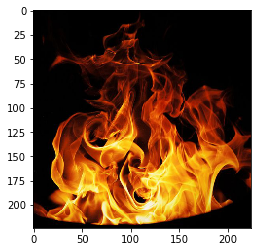

/home/cookiefactory/styletransfer/in4015/vgg19.npy
npy file loaded
build model started
build model finished: 0s


In [11]:
#create style data from style image
with tf.device(device):
    sess = tf.Session()
    
    #load style image
    input_img = get_image("./test_data/fire.jpg")  

    #input vgg
    input_image = tf.constant(input_img, tf.float32)
    
    #create style vgg()
    vgg = vgg19.Vgg19()    
    with tf.name_scope("style"):
        vgg.build(input_image)
    
    #layers
    style_layers = sess.run([vgg.pool4, vgg.pool3, vgg.pool2, vgg.pool1, vgg.conv1_1, vgg.conv4_1])
    
    #loop through layers and assign to style layers
    style_gram_layers = [tf.constant(style_layers[0]), tf.constant(style_layers[1]), tf.constant(style_layers[2]),
                    tf.constant(style_layers[3]), tf.constant(style_layers[4])]
    style_histogram_layers = [tf.constant(style_layers[5]), tf.constant(style_layers[4])]

    


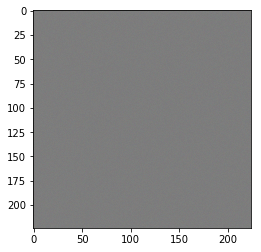

/home/cookiefactory/styletransfer/in4015/vgg19.npy
npy file loaded
build model started
build model finished: 0s


In [12]:
    #create target image
    target = tf.Variable((create_noise_image(224, 224, noise_min, noise_max)), tf.float32)
                 
    #create vgg  
    vgg = vgg19.Vgg19() 
    with tf.name_scope("target"):
        vgg.build(target)                 
    
    #target vgg
    target_gram_layers = [vgg.pool4, vgg.pool3, vgg.pool2, vgg.pool1, vgg.conv1_1]
    target_histogram_layers = [vgg.conv4_1, vgg.conv1_1]

In [13]:
#get losses
loss = get_loss(target_gram_layers, style_gram_layers)


In [14]:
i = 0
def callback(loss,target):
    global i
    target = tf.minimum(tf.maximum(target,0.0),1)

    if (optimizer_plot == True):
        wall_time = time.time() - start_time


    print(i, end = '')
    print(' ', end = '')

    if((i+1) % i_print == 0):

        #print loss
        print('')
        # loss_compute = sess.run(loss)
        print('Loss evaluation #', i, ', loss:', loss)
        
        if (optimizer_plot == True):
            loss_graph.append((wall_time, loss))

        #show image
        if(show == True):
            plt.imshow(sess.run(tf.reshape(target,(224,224,3))))
            plt.show()
    
    i += 1



#opt_iter = 0
#def callback(loss):
#    print('Loss evaluation #', opt_iter, ', loss:', loss)
#    opt_iter += 1

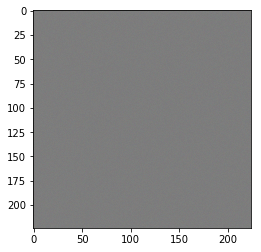

In [15]:
    learning_rate = 0.01
    #handlers
    if (opt == 'GD'): # Choose a better one. 
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        sess.run(tf.global_variables_initializer())
        minimize = optimizer.minimize(loss)
    elif (opt == 'Ad'):
        optimizer = tf.train.AdamOptimizer(learning_rate)
        sess.run(tf.global_variables_initializer())
        minimize = optimizer.minimize(loss)
    elif (opt == 'L'): 
        # ~10-25% faster than Adam
        #L-BFGS-B Optimizer not honoring maximum iterations given
        # see https://github.com/scipy/scipy/issues/3334
        optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss,method='L-BFGS-B',options={'maxfun': i_max})

        
        # with tf.Session() as session:
        sess.run(tf.global_variables_initializer())
        print("minimizing")
            
        if (optimizer_plot == True):
            start_time = time.time()
            
        optimizer.minimize(sess,fetches =[loss, target], loss_callback=callback)
        
        if (optimizer_plot == True):
            wall_time = time.time() - start_time
        print("minimized")
        print ('Task took {:.2f} seconds, {:.2f} seconds/iteration'.format(wall_time, wall_time/i_max))

    else:
        pass
    
    
    
    # print(sess.run(loss, feed_dict = feed))
    # print(sess.run(get_loss(target_layers, style_layers), feed_dict = feed))
    
    #show image
    if(show == True):
        plt.imshow(sess.run(tf.reshape(target,(224,224,3))))
        plt.show()
    

0 1 2 3 4 
[ 1.17101717  2.50994205  3.07389688  3.46505404  3.42265797]
[ 1.17101717  2.50994205  3.07389688  3.46505404  3.42265797]


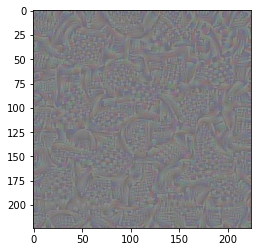

Task took 19.30 seconds, 3.86 seconds/iteration


In [16]:
    if (optimizer_plot == True):
        start_time = time.time()
        
    sess.run(tf.global_variables_initializer())
    for i in range(i_max):
        
        #optimize step
        sess.run(minimize)
        target = tf.minimum(tf.maximum(target,0.0),1)
        
        if (optimizer_plot == True):
            wall_time = time.time() - start_time
        
        
        print(i, end = '')
        print(' ', end = '')
        
        if((i+1) % i_print == 0):
            
            #print loss
            #print(sess.run(target_layers, feed_dict = feed))
            print('')
            loss_compute = sess.run(loss)
            print(loss_compute)
            # print(sess.run(loss, feed_dict = feed))
            print(sess.run(get_loss(target_gram_layers, style_gram_layers)))
        
            if (optimizer_plot == True):
                loss_graph.append((wall_time, loss_compute))
            
            #show image
            if(show == True):
                plt.imshow(sess.run(tf.reshape(target,(224,224,3))))
                plt.show()

    print ('Task took {:.2f} seconds, {:.2f} seconds/iteration'.format(wall_time, wall_time/i_max))


In [17]:
print(loss_graph)
# print(np.asarray(loss_graph))

[(19.2981915473938, array([ 1.17101717,  2.50994205,  3.07389688,  3.46505404,  3.42265797], dtype=float32))]


In [18]:
# Plot the loss over time
# loss_graph = np.asarray(loss_graph)
fig = plt.figure()
plot = plt.plot(loss_graph[:, 0], loss_graph[:, 1])
plt.xlabel('Wall time (seconds)', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim([90, 250])
fig.savefig('{}-{}.pdf'.format(opt,str(learning_rate).replace(".","")))

TypeError: list indices must be integers or slices, not tuple